<a href="https://colab.research.google.com/github/riccardobermeo/Lab_Econ_I/blob/master/LinearRegression_DecisionTree_PriceEstimation_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Colegio Bourbaki](./Images/Bourbaki.png)

## Rudimentos de Machine Learning

### Regresión Lineal y Árboles de Decisión

### Contexto

Link del dataset: https://challengedata.ens.fr/participants/challenges/68/

El Institut Louis Bachelier (ILB) es una red de investigación patrocinada en Economía y Finanzas. Es una asociación según la definición de la ley de 1901 y se creó en 2008 a instancias del Tesoro y la Caisse des Dépôts et Consignations. A través de sus actividades, pretende implicar a académicos, autoridades públicas y empresas en proyectos de investigación, así como en eventos científicos y otros foros de intercambio. Las decenas de proyectos de investigación que acoge el ILBf se centran en cuatro transiciones sociales: medioambiental, digital, demográfica y financiera.

El ILB Datalab es un equipo de científicos de datos que trabajan junto a investigadores de la red ILB en proyectos de investigación aplicada para agentes públicos y privados de nuestro ecosistema económico y financiero. El ILB datalab ha recopilado recientemente una gran cantidad de datos inmobiliarios franceses y le gustaría realizar análisis y experimentos con ellos. Este reto es una oportunidad para hacerlo.

Objetivos del reto

El proyecto es una tarea de regresión que trata sobre la estimación del precio de los inmuebles. La estimación del precio de los inmuebles de viviendas es un tema bastante común, con una importante bibliografía sobre la estimación de precios basada en datos habituales como: ubicación, superficie, terreno, número de dormitorios, antigüedad del edificio... Las aproximaciones suelen ser suficientes para estimar el rango de precios, pero carecen de precisión. Sin embargo, pocos han trabajado para ver si la adición de fotos del bien aportaría información complementaria, permitiendo una estimación más precisa del precio.

Así pues, el objetivo es trabajar en la modelización de los precios inmobiliarios de la vivienda francesa a partir de los datos tabulares jerárquicos habituales y, unas pocas fotos (entre 1 y 6) para cada bien y ver si permite un mejor rendimiento que un modelo entrenado sin las fotos.

Valoraremos la interpretabilidad de los resultados para comprender mejor las características valiosas.

**IMPORTANTE:** En nuestro caso, no utilizaremos las imágenes. Esta notebook solo será un análisis exploratorio al problema

Descripción de los datos

La salida y representa los precios inmobiliarios de vivienda ofrecidos de los activos franceses en euros.

### Librerias

In [2]:
#Data Analysis
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.tree import DecisionTreeRegressor

# Utils
import os
from IPython.display import Image, display
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler

#### Funciones de ayuda

In [3]:
def high_correlation_features(dataframe, threshold=0.95):
    """
    Identifies and returns pairs of highly correlated features from the given dataframe.

    Parameters:
    - dataframe: A pandas DataFrame containing the dataset.
    - threshold: A float representing the correlation threshold to identify high correlations.

    Returns:
    - A DataFrame with pairs of features that have a correlation coefficient above the threshold.
    """
    # Calculate the correlation matrix
    corr_matrix = dataframe.corr()

    # Find features with a correlation above the threshold
    # Note: The matrix is symmetric, so we need to filter out one side to avoid duplicates
    high_corr_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                       .stack()
                       .reset_index())
    high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
    high_corr_pairs = high_corr_pairs.loc[high_corr_pairs['Correlation'] > threshold, :]

    return high_corr_pairs

In [4]:
def normality_test(data):
    # D'Agostino-Pearson Test
    stat, p = stats.normaltest(data)
    print("D'Agostino-Pearson Test")
    print("Test Statistic:", stat)
    print("p-value:", p)
    if p < 0.05:
        print("Conclusion: According to the D'Agostino-Pearson Test, the data is not normally distributed.\n")
    else:
        print("Conclusion: According to the D'Agostino-Pearson Test, the data is normally distributed.\n")

    # Shapiro-Wilk Test
    stat, p = stats.shapiro(data)
    print("Shapiro-Wilk Test")
    print("Test Statistic:", stat)
    print("p-value:", p)
    if p < 0.05:
        print("Conclusion: According to the Shapiro-Wilk Test, the data is not normally distributed.\n")
    else:
        print("Conclusion: According to the Shapiro-Wilk Test, the data is normally distributed.\n")

    # Kolmogorov-Smirnov Test
    stat, p = stats.kstest(data, 'norm')
    print("Kolmogorov-Smirnov Test")
    print("Test Statistic:", stat)
    print("p-value:", p)
    if p < 0.05:
        print("Conclusion: According to the Kolmogorov-Smirnov Test, the data is not normally distributed.\n")
    else:
        print("Conclusion: According to the Kolmogorov-Smirnov Test, the data is normally distributed.\n")

    # Anderson-Darling Test
    result = stats.anderson(data)
    print("Anderson-Darling Test")
    print("Test Statistic:", result.statistic)
    for i in range(len(result.critical_values)):
        significance_level, critical_value = result.significance_level[i], result.critical_values[i]
        print(f'At {significance_level}% significance level, critical value is {critical_value}')
        if result.statistic > critical_value:
            print(f"Conclusion at {significance_level}% significance level: According to the Anderson-Darling Test, the data is not normally distributed.\n")
        else:
            print(f"Conclusion at {significance_level}% significance level: According to the Anderson-Darling Test, the data is normally distributed.\n")

In [5]:
def laplace_test(data):
    # Fit the data to a Laplace distribution and get the parameters
    loc, scale = stats.laplace.fit(data)

    # Kolmogorov-Smirnov Test for Laplace distribution
    stat, p = stats.kstest(data, 'laplace', args=(loc, scale))
    print("Kolmogorov-Smirnov Test for Laplace Distribution")
    print("Test Statistic:", stat)
    print("p-value:", p)
    if p < 0.05:
        print("Conclusion: According to the Kolmogorov-Smirnov Test, the data is not distributed like a Laplace distribution.\n")
    else:
        print("Conclusion: According to the Kolmogorov-Smirnov Test, the data is distributed like a Laplace distribution.\n")

### Carga de Datos

Vamos a leer los datos:

In [42]:
df_train = pd.read_csv('dataset_reto2_2.txt')
#Modificamos las etiquetas a minusculas
df_train.columns = df_train.columns.str.lower()


In [43]:
df_ytrain = df_train[['saleprice','id']] #SEPARA LA Y DEL DATASET SALEPRICE
#PASAR TODO A MINUSCULAS

In [47]:
#Quitamos la variable objetivo
df_train = df_train.drop(columns=['saleprice'])
df_train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [11]:
df_train.tail()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [13]:
df_train.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paveddrive

In [14]:
df_ytrain.head()

,saleprice
0,208500
1,181500
2,223500
3,140000
4,250000


In [15]:
df_ytrain.tail()

,saleprice
1455,175000
1456,210000
1457,266500
1458,142125
1459,147500


In [16]:
df_ytrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   saleprice  1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [17]:
df_ytrain.columns

Index(['saleprice'], dtype='object')

### Analisis Descriptivo

In [18]:
df_train.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [35]:
df_ytrain.describe()

,saleprice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


Veamos los valores nulos:

In [20]:
#Para el tratamiento de valores nulos primero investigaremos la caracteristicas de las variables para saber como rellenarla
#Una vez que se ha entendido el dataset con las descripciones procederemos a su modificación de la siguiente manera
print(df_train.dtypes)

id                 int64
mssubclass         int64
mszoning          object
lotfrontage      float64
lotarea            int64
                  ...   
miscval            int64
mosold             int64
yrsold             int64
saletype          object
salecondition     object
Length: 80, dtype: object


In [31]:
df_train['alley'] = df_train['alley'].fillna('NoAlley') # No hay callejón
df_train['bsmtexposure'] = df_train['bsmtexposure'].fillna('NoBsment') # Sin sótano
df_train['lotfrontage'] = df_train['lotfrontage'].fillna(0) # 0 pies conectados a la propiedad
df_train['masvnrtype'] = df_train['masvnrtype'].fillna('NoVnr') # Sin recubrimiento
df_train['masvnrarea'] = df_train['masvnrarea'].fillna(0) # Sin recubrimiento
df_train['bsmtqual'] = df_train['bsmtqual'].fillna('NoBsment') # Sin sótano
df_train['bsmtcond'] = df_train['bsmtcond'].fillna('NoBsment') # Sin sótano
df_train['bsmtfintype1'] = df_train['bsmtfintype1'].fillna('NoBsment') # Sin sótano
df_train['bsmtfintype2'] = df_train['bsmtfintype2'].fillna('NoBsment') # Sin sótano
df_train['fireplacequ'] = df_train['fireplacequ'].fillna('NoFirePlace') # Sin chimenea
df_train['garagetype'] = df_train['garagetype'].fillna('NoGrge') #Sin garage
df_train['garagefinish'] = df_train['garagefinish'].fillna('NoGrge') #Sin garage
df_train['garagequal'] = df_train['garagequal'].fillna('NoGrge') #Sin garage
df_train['garagecond'] = df_train['garagecond'].fillna('NoGrge') #Sin garage
df_train['poolqc'] = df_train['poolqc'].fillna('NoPool') #Sin alberca
df_train['fence'] = df_train['fence'].fillna('NoFence') #Sin cerca
df_train['miscfeature'] = df_train['miscfeature'].fillna('None') #Ninguna

# Al ser un único valor nulo, y ser una variable categórica, sustituímos por la moda
df_train['electrical'] = df_train['electrical'].fillna(df_train['electrical'].mode()[0])
df_train['garageyrblt'] = df_train['garageyrblt'].fillna(df_train['garageyrblt'].mode()[0])

In [32]:
df_train.isnull().sum()

id               0
mssubclass       0
mszoning         0
lotfrontage      0
lotarea          0
                ..
miscval          0
mosold           0
yrsold           0
saletype         0
salecondition    0
Length: 80, dtype: int64

In [33]:
# Obtener un DataFrame con el conteo de valores nulos por columna
null_counts = df_train.isnull().sum()

# Seleccionar las columnas que tienen valores nulos
columns_with_nulls = null_counts[null_counts > 0].index
columns_with_nulls

Index([], dtype='object')

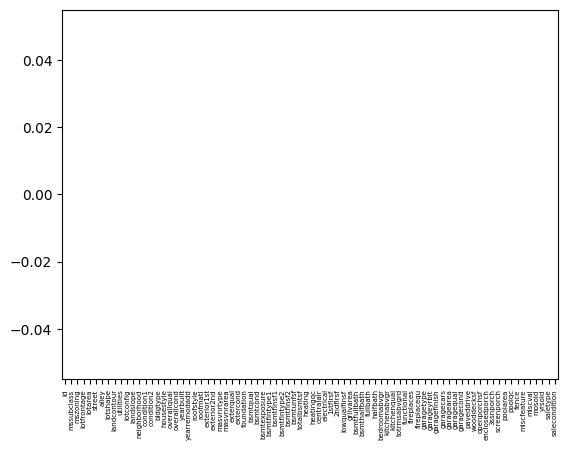

In [34]:
df_train.isnull().sum().plot(kind='bar')
plt.xticks(rotation=90, fontsize=5)
plt.show()

**Resumen estadístico:**

* El conjunto de datos contiene 1,460 filas con diversos atributos relacionados con anuncios inmobiliarios.
* El tamaño de las propiedades varía significativamente, con una media de aproximadamente 10,516 pies cuadrados, pero esto incluye algunos valores atípicos muy grandes, ya que el tamaño máximo es de 215,245 pies cuadrados.
* La variables LotFrontage marca valores cercanos a la media con 21 pies como mínimo y 313 pies como máximo
* Tanto overallquand y overallcount establecen la calidad de la propiedad en general, podemos observar que estos se comportan de manera de calificación con valores que van del 1 al 10 en general
* La Yearbult establece la fecha en que se construyo la propiedad, la cual vemos la presencia de propiedad con más de 100 años dados los valores del primer percentil y el mínimo valor
* El precio de las propiedades oscila entre 34,900 y 755,000, con un precio medio de aproximadamente 180,901.

**Valores Missing:**

* Se ha decidido realizar una sustitución apropiada para los valores nulos con el fin de mejorar la calidad de nuestro dataset, y no eliminar diversos registros que contienen información relevante

Vamos a hacer un merge de los dataframe para combinar características con los precios:

In [40]:
print("Columnas de df_train:", df_train.columns)

# Verificar columnas de df_ytrain
print("Columnas de df_ytrain:", df_ytrain.columns)

Columnas de df_train: Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'ga

In [48]:
df = pd.merge(df_train, df_ytrain, on='id', how='inner')

### Distribuciones de los datos

In [ ]:
#AQUÍ VER LAS VARIABLES IMPORTANTES SALEPRICE,

In [49]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


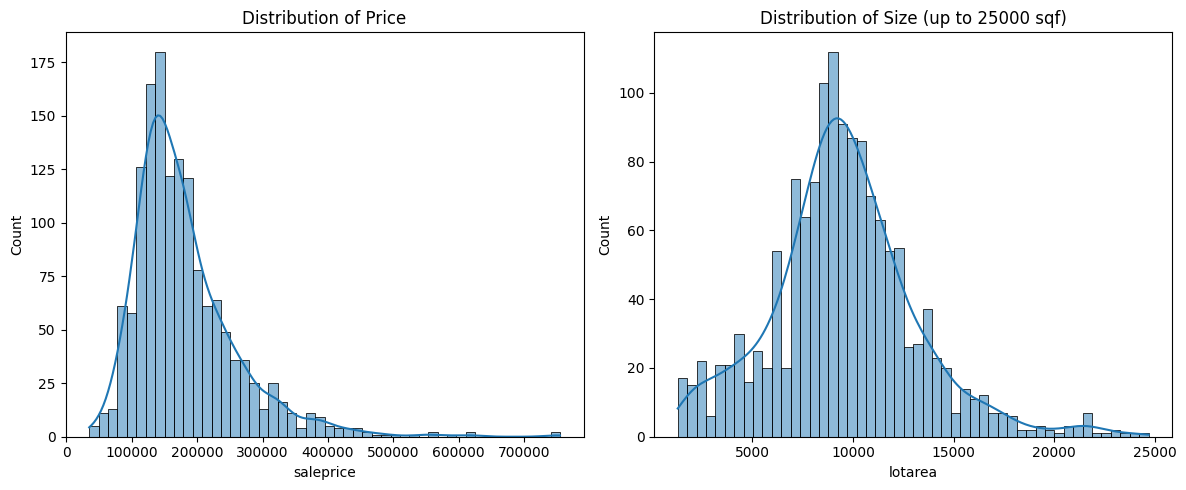

In [57]:
# Distribution Analysis for 'price' and 'size'
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['saleprice'], bins=50, kde=True)
plt.title('Distribution of Price')

plt.subplot(1, 2, 2)
sns.histplot(df[df['lotarea'] < 25000]['lotarea'], bins=50, kde=True)  # Limiting size to filter extreme outliers for visualization
plt.title('Distribution of Size (up to 25000 sqf)')

plt.tight_layout()
plt.show()

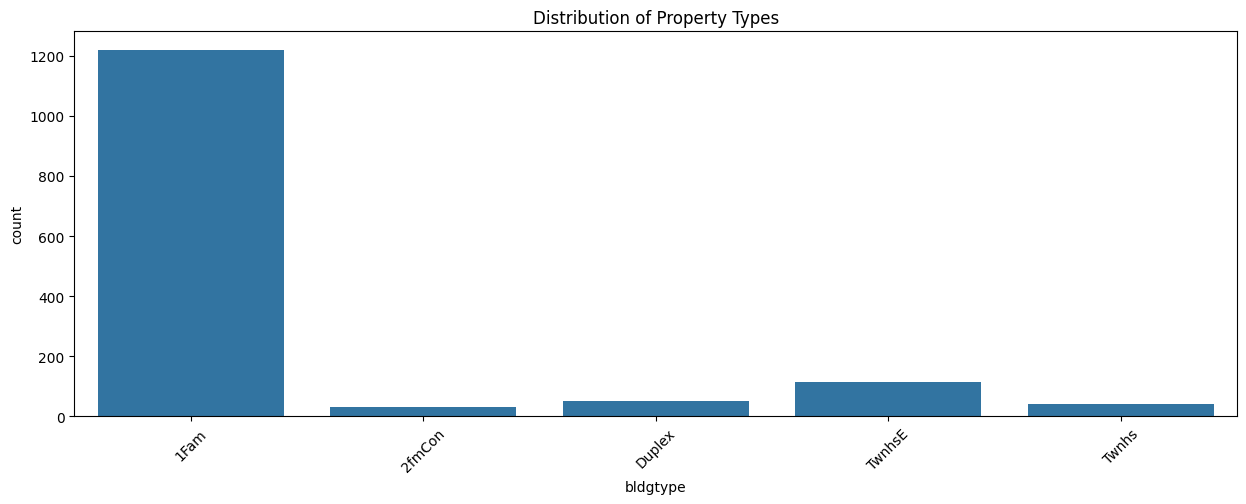

In [59]:
# Categorical Data Analysis: Property Type Distribution
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x='bldgtype')
plt.title('Distribution of Property Types')
plt.xticks(rotation=45)
plt.show()

In [60]:
# Average Price by City (Top 10 cities for demonstration)
avg_price_by_city = df.groupby('neighborhood')['saleprice'].mean().sort_values(ascending=False).head(10)

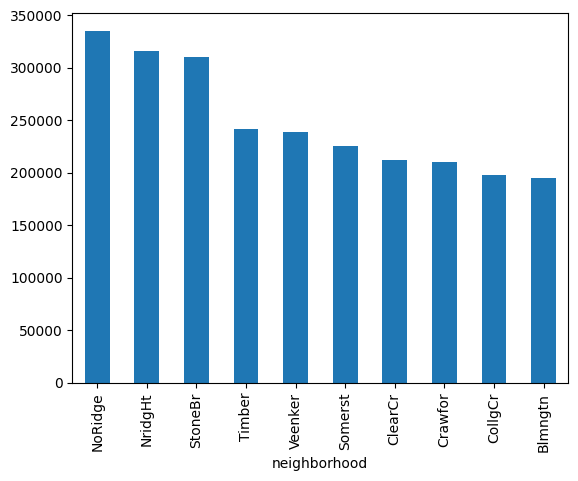

In [61]:
avg_price_by_city.plot(kind='bar')
plt.show()

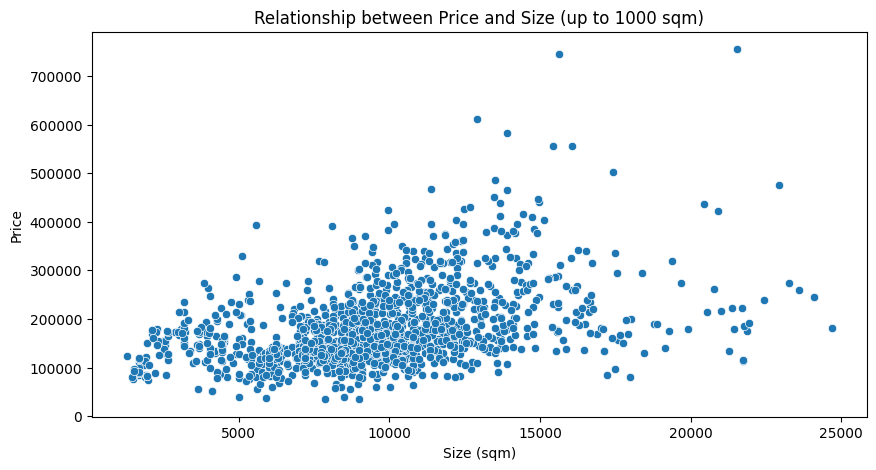

In [65]:
# Numerical Variables Analysis: Relationship between Price and Size
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df[df['lotarea'] < 25000], x='lotarea', y='saleprice')  # Limiting to realistic property sizes for visualization
plt.title('Relationship between Price and Size (up to 1000 sqm)')
plt.xlabel('Size (sqm)')
plt.ylabel('Price')
plt.show()

In [67]:
# Categorical Variables Analysis: Property Type Distribution and Average Price
property_type_avg_price = df.groupby('bldgtype')['saleprice'].mean().sort_values(ascending=False)

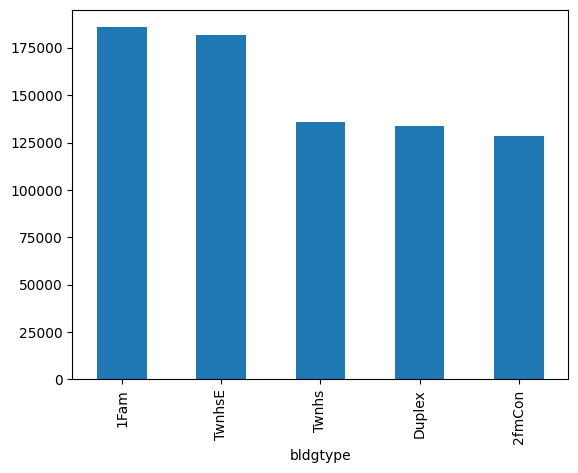

In [68]:
property_type_avg_price.plot(kind='bar')
plt.show()

Vamos a deshacernos de ciertas variables categóricas:

In [ ]:
#AQUI ELIMINAR VARIABLES

In [69]:
columns_to_drop = ['street', 'lotshape', 'utilities', 'lotconfig','landslope', 'condition2',
              'overallcond', 'roofmatl', 'exterior1st', 'exterior2nd', 'extercond',
              'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'heating', 'electrical',
              'kitchenabvgr', 'functional', 'garagetype',  'garagecond', '3ssnporch',
              'screenporch', 'poolarea', 'poolqc',  'miscfeature', 'miscval', 'mosold',
              'yrsold',  'salecondition', 'id']

In [70]:
df_drop = df.drop(columns_to_drop, axis=1)

Vamos a pasar a númericas la variable categórica property_type:

In [71]:
def analize_categorical(df, target, var_cat, bool_plot=False, size=None, bool_print=True):
    df_mean_by_cat = pd.DataFrame(df.groupby([var_cat])[target].mean()).join(
        pd.DataFrame(df.groupby(var_cat).size(), columns=['count'])).sort_values(by=target, ascending=True)
    ordered_categ = list(df_mean_by_cat.index)

    if bool_print:
        print('La variable ' + var_cat + ' tiene {}'.format(df[var_cat].isnull().sum()) + ' valores nulos.')
        print(df_mean_by_cat)

    if bool_plot:
        if size==None:
            size = (len(ordered_categ)+1,4)
        sns.set_style('darkgrid')
        fig, axes = plt.subplots(1, 2, figsize=size)#, sharex=True)
        fig.suptitle('Valor medio y distribución de precios segmentando por: '+var_cat)
        ax1 = df_mean_by_cat[target].plot(kind='bar', ax=axes[0], color=COLOR_LAYOUT[1])

        plt.figure(figsize=(len(ordered_categ)/2+1,4))
        sns.boxplot(data=df, x=var_cat, y=target, width=0.5, palette=COLOR_LAYOUT, order=ordered_categ, ax=axes[1])
    return ordered_categ

def encode_categorical(df, var_cat, ordered_categ, bool_print=True):
    dict_encoding = {}
    i = 1
    for cat in ordered_categ:
        dict_encoding[cat] = i
        i = i+1
    df[var_cat] = df[var_cat].map(dict_encoding)
    if bool_print:
        print(df.groupby(var_cat).size())

In [75]:
categoricas = ['mssubclass', 'alley', 'landcontour', 'neighborhood', 'condition1', 'bldgtype',
               'housestyle', 'masvnrtype', 'foundation', 'centralair']

ordenadas = ['mszoning', 'overallqual', 'exterqual', 'bsmtqual', 'bsmtcond', 'bsmtexposure',
             'bsmtfintype1', 'heatingqc', 'kitchenqual', 'fireplacequ', 'garagefinish',
             'garagequal', 'paveddrive']

numericas = ['lotfrontage', 'lotarea', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
             'totalbsmtsf','1stflrsf','2ndflrsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
             'fullbath', 'halfbath', 'bedroomabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars',
             'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch']


In [77]:
target='saleprice'

In [79]:
for var_cat in ordenadas:
    ordered_categ = analize_categorical(df_drop, target, var_cat, bool_plot=False, bool_print=False)
    encode_categorical(df_drop, var_cat, ordered_categ, bool_print=False)
    #obtiene el orden  #Quitar aire #

In [82]:
df[categoricas].dtypes

mssubclass      object
alley           object
landcontour     object
neighborhood    object
condition1      object
bldgtype        object
housestyle      object
masvnrtype      object
foundation      object
centralair      object
dtype: object

In [81]:
df['mssubclass'] = df['mssubclass'].astype(object)

In [83]:
df_drop = pd.get_dummies(df_drop) #CAMBIAR A OBJETO/

In [84]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 122 entries, mssubclass to saletype_WD
dtypes: bool(83), float64(10), int64(29)
memory usage: 563.3 KB


In [85]:
df_drop.head()

,mssubclass,mszoning,lotfrontage,lotarea,overallqual,yearbuilt,yearremodadd,masvnrarea,exterqual,bsmtqual,...,fence_MnWw,saletype_COD,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD
0,60,4,65.0,8450,7,2003,2003,196.0,3,3.0,...,False,False,False,False,False,False,False,False,False,True
1,20,4,80.0,9600,6,1976,1976,0.0,2,3.0,...,False,False,False,False,False,False,False,False,False,True
2,60,4,68.0,11250,7,2001,2002,162.0,3,3.0,...,False,False,False,False,False,False,False,False,False,True
3,70,4,60.0,9550,7,1915,1970,0.0,2,2.0,...,False,False,False,False,False,False,False,False,False,True
4,60,4,84.0,14260,8,2000,2000,350.0,3,3.0,...,False,False,False,False,False,False,False,False,False,True


Vamos a chequear la cantidad de variables que hay en las características categóricas:

In [86]:
#Check the value counts for all object type columns
df.select_dtypes(include=['object']).nunique()

mssubclass       15
mszoning          5
street            2
alley             2
lotshape          4
landcontour       4
utilities         2
lotconfig         5
landslope         3
neighborhood     25
condition1        9
condition2        8
bldgtype          5
housestyle        8
roofstyle         6
roofmatl          8
exterior1st      15
exterior2nd      16
masvnrtype        3
exterqual         4
extercond         5
foundation        6
bsmtqual          4
bsmtcond          4
bsmtexposure      4
bsmtfintype1      6
bsmtfintype2      6
heating           6
heatingqc         5
centralair        2
electrical        5
kitchenqual       4
functional        7
fireplacequ       5
garagetype        6
garagefinish      3
garagequal        5
garagecond        5
paveddrive        3
poolqc            3
fence             4
miscfeature       4
saletype          9
salecondition     6
dtype: int64

In [87]:
#show the value counts for each column
for col in df.select_dtypes(include=['object']).columns:
    print(df[col].value_counts())
    print()

mssubclass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: count, dtype: int64

mszoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

street
Pave    1454
Grvl       6
Name: count, dtype: int64

alley
Grvl    50
Pave    41
Name: count, dtype: int64

lotshape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64

landcontour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

lotconfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64

landslope
Gtl    1382
Mod      65
Sev      13
Name: count, dtype: int64

neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes   

Vamos a chequear nuevamente las columnas:

In [88]:
df.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paveddrive

Podemos visualizar que el las columnas id_annonce, city, postal_code y nb_photos pueden ser retiradas en un principio ya que no aportarian valor. La ciudad puede ser calculadada con la latitud y longitud aproximada. Las fotos no nos interesan en este problema. La categoria de performance energetico hace referencia al valor numérico de performance, entonces sería redundante. Lo mismo para ghg_category.

In [89]:
df_lr = df.drop(columns_to_drop, axis=1)

In [90]:
df_lr = pd.get_dummies(df_lr)

In [91]:
df_lr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 176 entries, lotfrontage to saletype_WD
dtypes: bool(150), float64(3), int64(23)
memory usage: 510.6 KB


Vamos a chequear correlaciones:

In [92]:
correlated_features = high_correlation_features(df_lr)

In [93]:
correlated_features

,Feature 1,Feature 2,Correlation
5720,mssubclass_90,bldgtype_Duplex,1.000000
6265,mssubclass_190,bldgtype_2fmCon,0.983395


Vemos que no hay fuerte correlación en las columnas.

Veamos qué podemos hacer con los valores nulos.

In [94]:
df_lr.isnull().sum()

lotfrontage       259
lotarea             0
overallqual         0
yearbuilt           0
yearremodadd        0
                 ... 
saletype_ConLI      0
saletype_ConLw      0
saletype_New        0
saletype_Oth        0
saletype_WD         0
Length: 176, dtype: int64

Vamos a hacer una imputación simple:

In [98]:
numerical_cols = df_lr.select_dtypes(include=['number']).columns

In [99]:
# Imputing missing values with their median
imputer = SimpleImputer(strategy='median')
df_lr[numerical_cols] = imputer.fit_transform(df_lr[numerical_cols])

In [100]:
df_lr.isnull().sum()

lotfrontage       0
lotarea           0
overallqual       0
yearbuilt         0
yearremodadd      0
                 ..
saletype_ConLI    0
saletype_ConLw    0
saletype_New      0
saletype_Oth      0
saletype_WD       0
Length: 176, dtype: int64

Ejercicio:

Considerando lo siguiente:
appartement - apartamento
maison - casa
divers - diversos
terrain - terreno
villa - villa
propriété - propiedad
terrain à bâtir - terreno para construir
duplex - dúplex
viager - viager
ferme - granja
parking - aparcamiento
loft - loft
chalet - chalet
château - castillo
moulin - molino
manoir - mansión
péniche - casa flotante
hôtel particulier - mansión
chambre - habitación
gîte - casa rural
atelier - taller
hôtel - hotel

**Cómo rellenaría los valores nulos?**

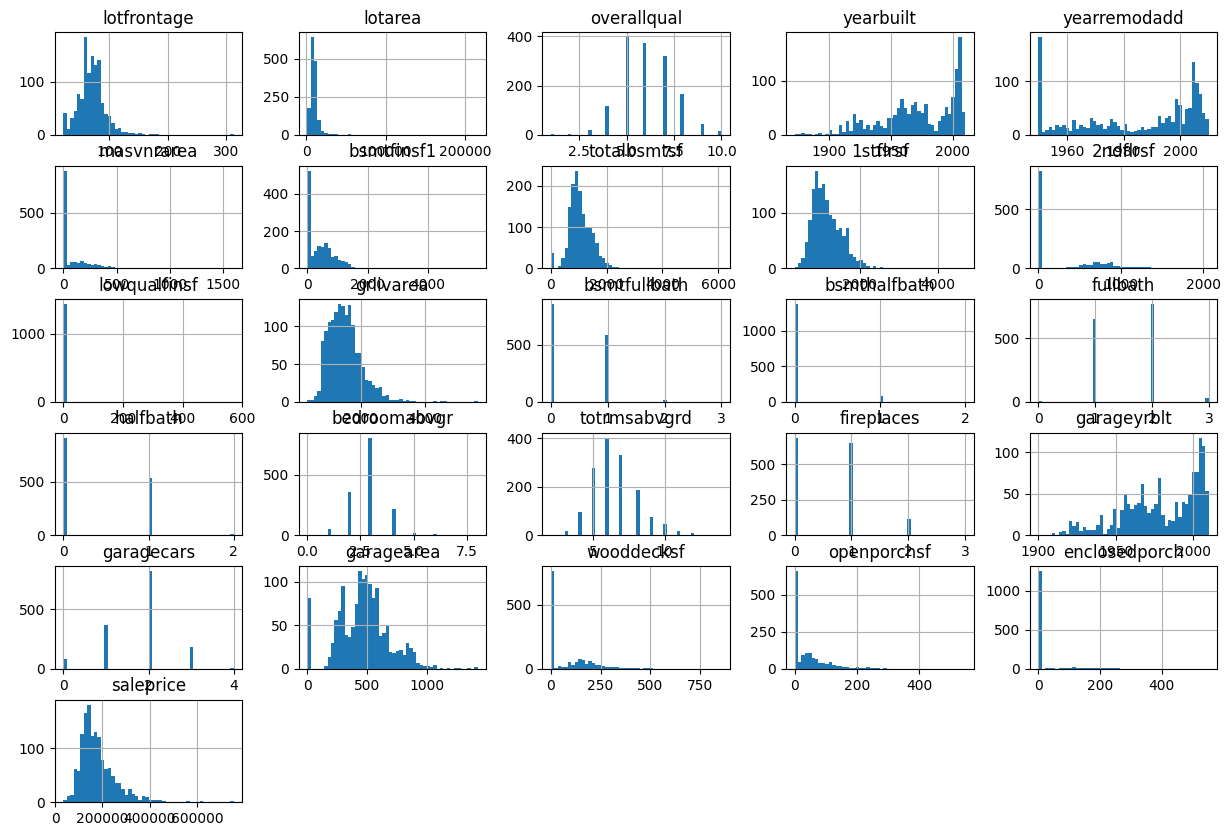

In [101]:
#plot the distributions of all numerical columns
df[numerical_cols].hist(bins=50, figsize=(15, 10), sharex=False, sharey=False)
plt.show()

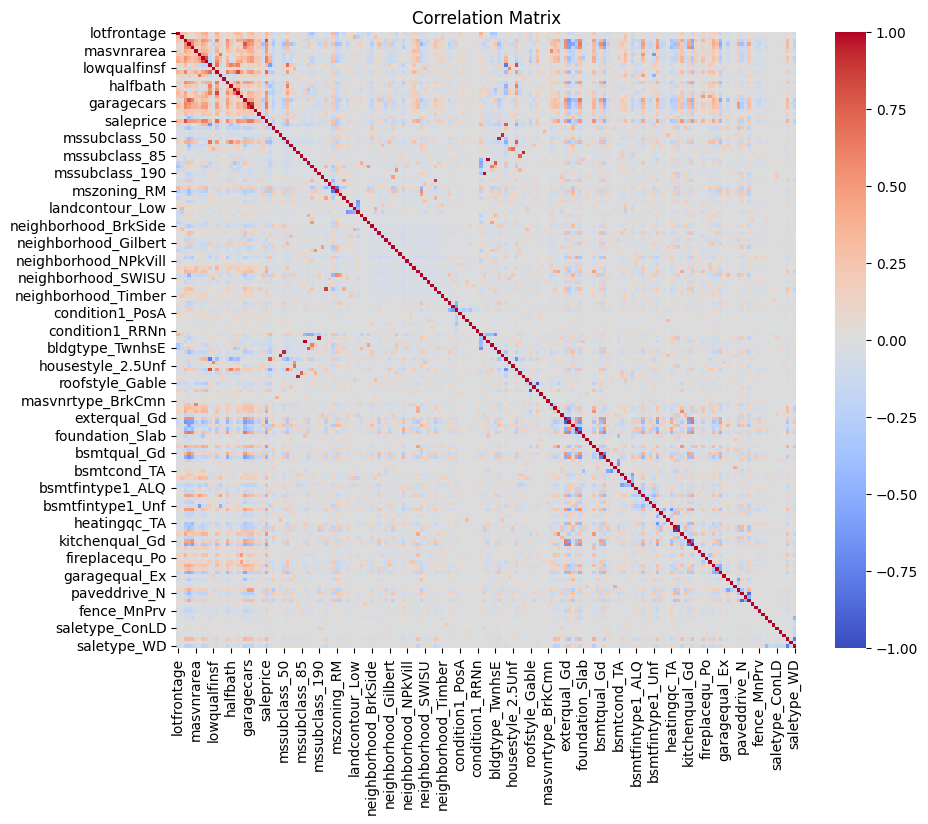

In [102]:
# Correlation Analysis
correlation_matrix = df_lr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [104]:
# Detailed Correlation Analysis focusing on Price
price_correlation = df_lr.corr()['saleprice'].sort_values(ascending=False)

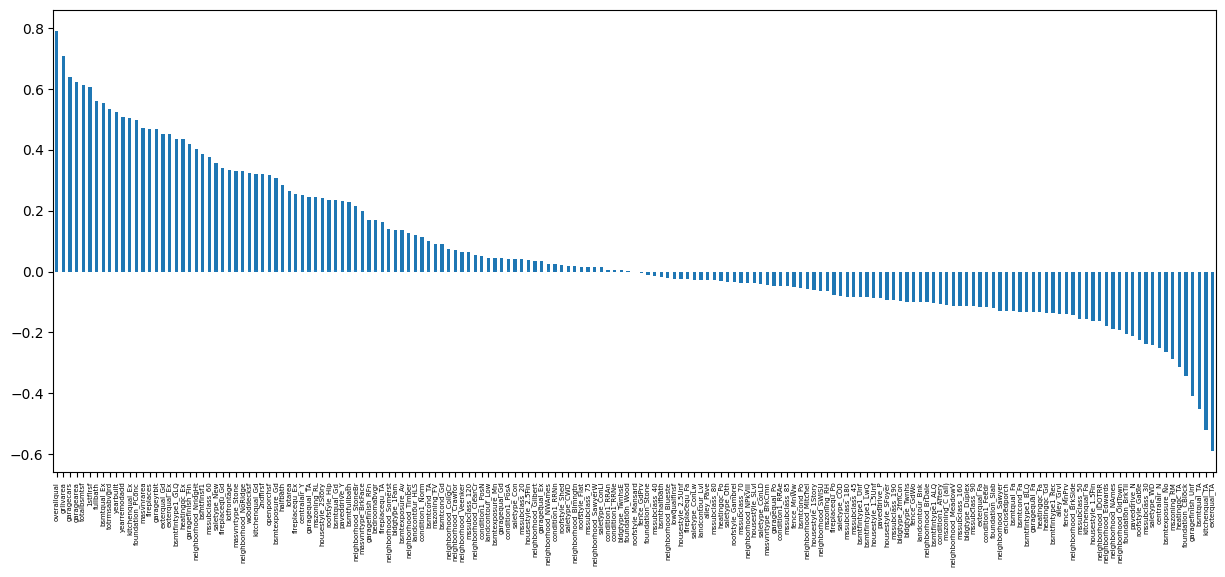

In [106]:
price_correlation.drop('saleprice').plot(kind='bar', figsize=(15, 6))
plt.xticks(rotation=90, fontsize=5)
plt.show()

### Regresión Lineal

In [107]:
#Min max scaler
scaler = MinMaxScaler()
columns = df_lr.columns
df_lr = scaler.fit_transform(df_lr)

In [108]:
df_lr = pd.DataFrame(df_lr, columns=columns)

In [111]:
# Splitting the dataset into features (X) and target (y)
X = df_lr.drop(['saleprice'], axis=1)
y = df_lr['saleprice']

In [112]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [113]:
# Display the shape of the training and testing sets to confirm successful split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1168, 175), (292, 175), (1168,), (292,))

In [140]:
# Selección de características con Lasso
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
lasso = Lasso(alpha=0.001).fit(X_train, y_train)
model = SelectFromModel(lasso, prefit=True)
X_train_selected = model.transform(X_train)
X_test_selected = model.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [142]:
# Selección de características con Lasso
lasso = Lasso(alpha=0.001).fit(X_train, y_train)
model = SelectFromModel(lasso, prefit=True)
X_train_selected = model.transform(X_train)
X_test_selected = model.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [143]:
X_train_selected

array([[0.44444444, 0.11666667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.55555556, 0.73333333, 0.37384988, ..., 0.        , 0.        ,
        0.        ],
       [0.44444444, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.44444444, 0.66666667, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.66666667, 0.8       , 0.24891041, ..., 0.        , 1.        ,
        0.        ],
       [0.66666667, 0.95      , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [161]:
# Definir los parámetros para la búsqueda
param_grid = {
    'ridge': {'alpha': [0.1, 1.0, 10.0, 100.0]},
}

# Probar un modelo simple de Ridge
ridge_simple = Ridge()
ridge_simple.fit(X_train_selected, y_train)

# Predicciones
y_pred_train_ridge = ridge_simple.predict(X_train_selected)
y_pred_test_ridge = ridge_simple.predict(X_test_selected)

# Evaluar el modelo
mse_ridge_train = mean_squared_error(y_train, y_pred_train_ridge)
r2_ridge_train = r2_score(y_train, y_pred_train_ridge)
mse_ridge_test = mean_squared_error(y_test, y_pred_test_ridge)
r2_ridge_test = r2_score(y_test, y_pred_test_ridge)

print(f'Ridge Simple - MSE Train: {mse_ridge_train}, R2 Train: {r2_ridge_train}')
print(f'Ridge Simple - MSE Test: {mse_ridge_test}, R2 Test: {r2_ridge_test}')

Ridge Simple - MSE Train: 0.0016325564914511316, R2 Train: 0.8580693705765675
Ridge Simple - MSE Test: 0.0019343228886435123, R2 Test: 0.8692322177416463


In [147]:
print(f'MSE Train LR: {mse_ridge_train},  R2 Train LR: {r2_ridge_train}')

MSE Train LR: 0.0016325564914511316,  R2 Train LR: 0.8580693705765675


In [148]:
print(f'MSE Test LR: {mse_ridge_test}, R2 Test LR: {r2_ridge_test}')

MSE Test LR: 0.0019343228886435123, R2 Test LR: 0.8692322177416463


In [149]:
cross_val_score(linear_model, X, y, cv=10, verbose=1, scoring='neg_root_mean_squared_error')

array([-3.19133245e-02, -3.75491366e-02, -3.85625877e+09, -5.60720646e-02,
       -4.75981593e-02, -2.64503141e+08, -9.62039729e+07, -3.56574109e-02,
       -1.99203286e+08, -3.73242376e-02])

In [151]:
# Calcular los residuos para el mejor modelo
y_train_pred = ridge_simple.predict(X_train_selected)
y_test_pred = ridge_simple.predict(X_test_selected)

residuos_train = y_train - y_train_pred
residuos_test = y_test - y_test_pred

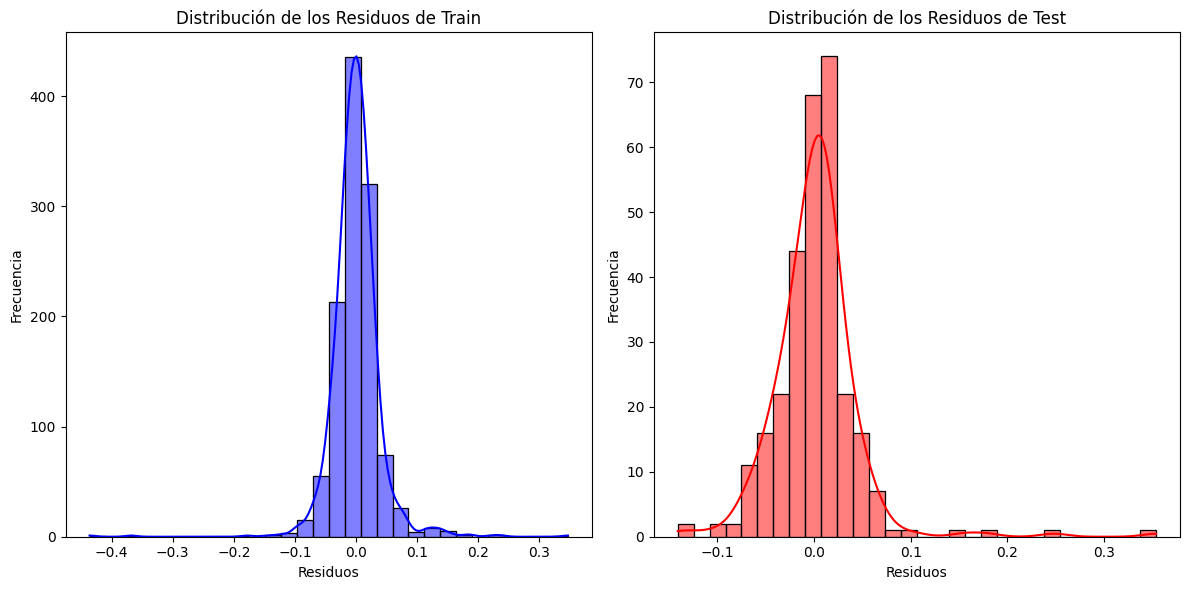

In [153]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuos_train, kde=True, color='blue', bins=30)
plt.title('Distribución de los Residuos de Train')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.histplot(residuos_test, kde=True, color='red', bins=30)
plt.title('Distribución de los Residuos de Test')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

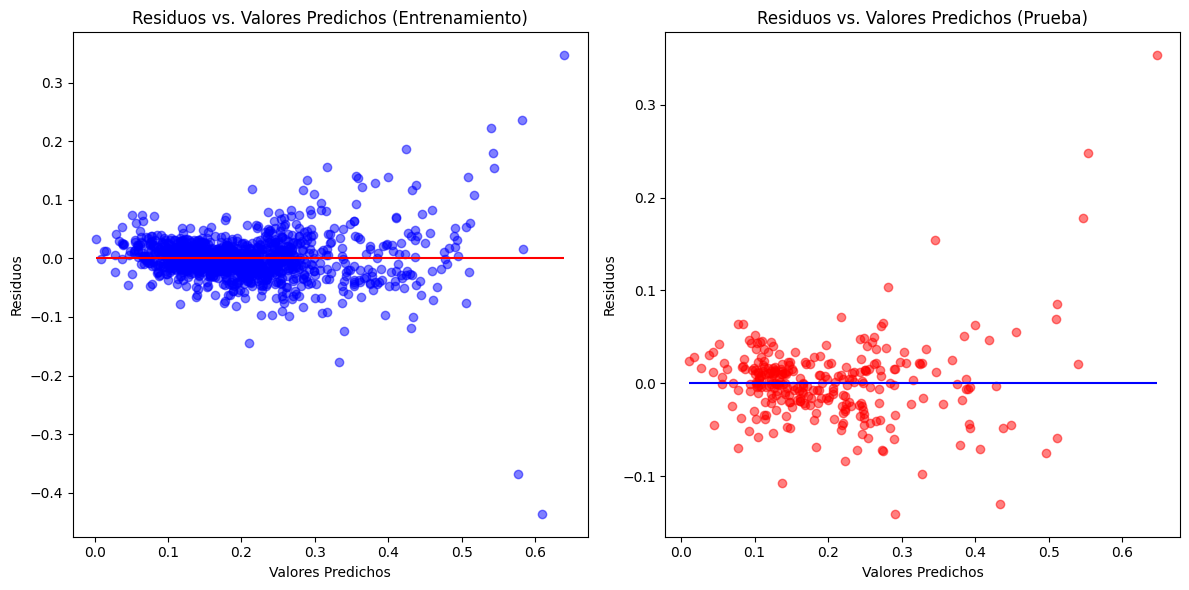

In [154]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, residuos_train, color='blue', alpha=0.5)
plt.hlines(y=0, xmin=min(y_train_pred), xmax=max(y_train_pred), colors='red')
plt.title('Residuos vs. Valores Predichos (Entrenamiento)')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, residuos_test, color='red', alpha=0.5)
plt.hlines(y=0, xmin=min(y_test_pred), xmax=max(y_test_pred), colors='blue')
plt.title('Residuos vs. Valores Predichos (Prueba)')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')

plt.tight_layout()
plt.show()

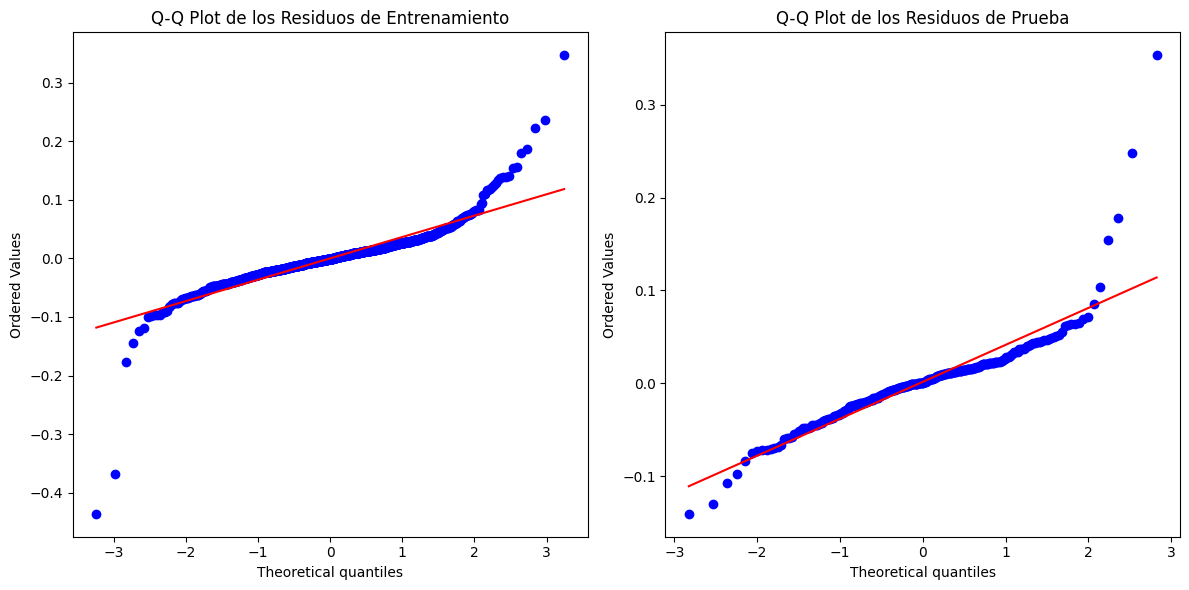

In [155]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
stats.probplot(residuos_train, dist="norm", plot=plt)
plt.title('Q-Q Plot de los Residuos de Entrenamiento')

plt.subplot(1, 2, 2)
stats.probplot(residuos_test, dist="norm", plot=plt)
plt.title('Q-Q Plot de los Residuos de Prueba')

plt.tight_layout()
plt.show()

* Histograma de los Residuos: Debería aproximarse a una distribución normal. Si los residuos no se distribuyen normalmente, puede indicar que el modelo no captura todas las variaciones de los datos. En este caso observamos que existe una campana cercana a la de Gaus, pero con ayuda de pruebas de normalidad comprobaremos lo que vemos visualmente
*Gráfico de Residuos vs. Valores Predichos: Los residuos deberían estar distribuidos aleatoriamente alrededor de cero sin mostrar patrones claros. Patrones en los residuos pueden indicar que hay relaciones no capturadas por el modelo. En este caso no se observa ningun patron claro, por lo que los errores no arrojan información relevante al modelado
*Gráfico Q-Q: Si los residuos siguen una línea recta en el gráfico Q-Q, esto sugiere que los residuos están normalmente distribuidos. Se observa que algunos valores se separan un poco en las colas, sin embargo no existe una prueba robusta para establecer dicha hipotesis

In [157]:
# Prueba de Shapiro-Wilk
from scipy.stats import shapiro, kstest, jarque_bera
shapiro_train_stat, shapiro_train_p = shapiro(residuos_train)
shapiro_test_stat, shapiro_test_p = shapiro(residuos_test)

print(f"Shapiro-Wilk Test (Train) - Estadístico: {shapiro_train_stat}, p-Valor: {shapiro_train_p}")
print(f"Shapiro-Wilk Test (Test) - Estadístico: {shapiro_test_stat}, p-Valor: {shapiro_test_p}")

Shapiro-Wilk Test (Train) - Estadístico: 0.8162192181712116, p-Valor: 1.6220650436843298e-34
Shapiro-Wilk Test (Test) - Estadístico: 0.8184875301658922, p-Valor: 8.515629333781853e-18


In [158]:
# Prueba de Kolmogorov-Smirnov
kstest_train_stat, kstest_train_p = kstest(residuos_train, 'norm', args=(np.mean(residuos_train), np.std(residuos_train)))
kstest_test_stat, kstest_test_p = kstest(residuos_test, 'norm', args=(np.mean(residuos_test), np.std(residuos_test)))

print(f"Kolmogorov-Smirnov Test (Train) - Estadístico: {kstest_train_stat}, p-Valor: {kstest_train_p}")
print(f"Kolmogorov-Smirnov Test (Test) - Estadístico: {kstest_test_stat}, p-Valor: {kstest_test_p}")

Kolmogorov-Smirnov Test (Train) - Estadístico: 0.10537653486297605, p-Valor: 9.53346715617781e-12
Kolmogorov-Smirnov Test (Test) - Estadístico: 0.13507783574730337, p-Valor: 4.1554601536393514e-05


In [159]:
# Prueba de Jarque-Bera
jarque_bera_train_stat, jarque_bera_train_p = jarque_bera(residuos_train)
jarque_bera_test_stat, jarque_bera_test_p = jarque_bera(residuos_test)

print(f"Jarque-Bera Test (Train) - Estadístico: {jarque_bera_train_stat}, p-Valor: {jarque_bera_train_p}")
print(f"Jarque-Bera Test (Test) - Estadístico: {jarque_bera_test_stat}, p-Valor: {jarque_bera_test_p}")

Jarque-Bera Test (Train) - Estadístico: 29800.470168884465, p-Valor: 0.0
Jarque-Bera Test (Test) - Estadístico: 3997.721320472671, p-Valor: 0.0


En las pruebas estadísticas a partir de p-value se observa que se apruba la hipotesis de normalidad, bajo los tres estadísticos anteriormente preentados, por lo que concluimos que los errores se distribuyen de manera normal.

In [ ]:
#Aqui poner las gráficas de abajo de regresión
#Podemos ocupar otra métricas de regresión

### Preguntas

**Comprensión Básica**

1) ¿Qué es la Regresión Lineal
2) ¿Qué son los Árboles de Decisión?
3) ¿Cómo predice resultados la Regresión Lineal?
4) ¿Cuál es la diferencia entre la Regresión Lineal y los Árboles de Decisión?

**Comprensión Intermedia**

5) ¿Qué es el sobreajuste y cómo puede afectar el rendimiento de la Regresión Lineal y los Árboles de Decisión?
6) ¿Cómo evalúas el rendimiento de un modelo de Regresión Lineal?
7) ¿Pueden los Árboles de Decisión manejar datos numéricos y categóricos? Explica cómo.

**Comprensión Avanzada**

8) Discute cómo prevenirías el sobreajuste en un modelo de Árbol de Decisión.
9) Explica el concepto de "importancia de características" en el contexto de los Árboles de Decisión.
10) En la Regresión Lineal, ¿cómo interpretas los coeficientes de las características?

**Ejercicio:** Comprobar los resultados utilizando Z-Score en vez del escalado MinMax

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)